# Installs

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 173.5 MB 61 kB/s               
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
#from datetime import datetime
import datetime
#from pyathena import connect
import random

Matplotlib is building the font cache; this may take a moment.


In [3]:
from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

In [4]:
import numpy as np
import pandas as pd

import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor    
# from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
print("OK")

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics

from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from xgboost import plot_importance

import boto3

OK


## Load Data

In [5]:
# Read from S3 - Enter filename for Key
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='sagemaker-w210-eth', Key='pipeline_df_20211115_1_non_winsorized.csv')
data = pd.read_csv(obj['Body'])
data.head()

,number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,...,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
0,12965000,2021-08-05 12:32:42,NaN,2021-08-05 12:33:42,7742494561645080,2.849441e+22,137049,30029122,30025257,1628166822,...,-0.141907,-0.071168,0.266887,-0.079218,-0.290970,-0.472032,0.269608,0.457143,0.165714,0.079365
1,12965001,2021-08-05 12:32:55,NaN,2021-08-05 12:33:55,7742495635386904,2.849442e+22,158678,29999798,29985144,1628166835,...,0.064655,-0.344422,0.010515,0.204574,-0.011364,-0.246282,0.809859,-0.095541,-0.059603,0.526882
2,12965002,2021-08-05 12:33:14,NaN,2021-08-05 12:34:14,7738716193681762,2.849442e+22,96685,29970503,29950343,1628166854,...,-0.145583,-0.231084,-0.306255,0.424811,0.105377,-0.142948,0.957317,0.197080,0.171429,0.301587
3,12965003,2021-08-05 12:33:17,NaN,2021-08-05 12:34:17,7742495937440032,2.849443e+22,86936,29941236,29933895,1628166857,...,-0.161172,-0.121338,0.203611,-0.161571,-0.221601,-0.282230,0.790541,0.138462,0.193548,0.138462
4,12965004,2021-08-05 12:33:28,NaN,2021-08-05 12:34:28,7742497011181856,2.849444e+22,89206,29911998,29895283,1628166868,...,0.271640,0.429554,0.708066,-0.024784,-0.069420,-0.203417,0.931034,47.333333,-0.211957,-0.299517


In [6]:
data.rename(columns={'number': 'block_number'}, inplace=True)

In [7]:
data.head()

,block_number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,...,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
0,12965000,2021-08-05 12:32:42,NaN,2021-08-05 12:33:42,7742494561645080,2.849441e+22,137049,30029122,30025257,1628166822,...,-0.141907,-0.071168,0.266887,-0.079218,-0.290970,-0.472032,0.269608,0.457143,0.165714,0.079365
1,12965001,2021-08-05 12:32:55,NaN,2021-08-05 12:33:55,7742495635386904,2.849442e+22,158678,29999798,29985144,1628166835,...,0.064655,-0.344422,0.010515,0.204574,-0.011364,-0.246282,0.809859,-0.095541,-0.059603,0.526882
2,12965002,2021-08-05 12:33:14,NaN,2021-08-05 12:34:14,7738716193681762,2.849442e+22,96685,29970503,29950343,1628166854,...,-0.145583,-0.231084,-0.306255,0.424811,0.105377,-0.142948,0.957317,0.197080,0.171429,0.301587
3,12965003,2021-08-05 12:33:17,NaN,2021-08-05 12:34:17,7742495937440032,2.849443e+22,86936,29941236,29933895,1628166857,...,-0.161172,-0.121338,0.203611,-0.161571,-0.221601,-0.282230,0.790541,0.138462,0.193548,0.138462
4,12965004,2021-08-05 12:33:28,NaN,2021-08-05 12:34:28,7742497011181856,2.849444e+22,89206,29911998,29895283,1628166868,...,0.271640,0.429554,0.708066,-0.024784,-0.069420,-0.203417,0.931034,47.333333,-0.211957,-0.299517


In [8]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_pct_chg_last_25_to_5',
       'base_fee_per_gas_pct_chg_last_50_to_5',
       'base_fee_per_gas_pct_chg_last_100_

In [9]:
print("min block number:", data.block_number.min())
print("median block number:", data.block_number.median())
print("max block number:", data.block_number.max())

min block number: 12965000
median block number: 13246123.0
max block number: 13527858


In [10]:
# print("length of data before dropping NAs:", len(data))
# data = data.dropna()
# print("length of data after dropping NAs:", len(data))

In [11]:
pd.options.display.max_columns = None
data.describe()

,block_number,latest_avail_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
count,5.537010e+05,5.536960e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,5.536760e+05,5.536510e+05,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,553676.000000,553651.000000,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,553697.000000,553692.000000,553672.000000,553647.000000,553597.000000,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000
mean,1.324632e+07,1.324631e+07,8.887769e+15,3.087335e+22,7.848288e+04,3.001038e+07,1.570156e+07,1.631931e+09,191.923693,8.391257e+10,0.000004,0.000015,0.000033,0.000070,1.460685e-06,5.842754e-06,1.314624e-05,0.000028,1.897053,1.898676,1.931698,1.970818,8.186505e-07,0.000001,0.000002,0.000004,0.012125,0.031613,0.061971,0.086735,78482.656935,0.092125,0.088190,0.103078,0.118182,2.159017e+04,1.888499e+05,8.548464e+10,1.025643e+11,2.127177e+04,8.899167e+04,8.548464e+10,1.025643e+11,191.923693,0.125565,0.133592,0.137878,0.142568,0.029485,0.056133,0.084671,0.112852,0.103634,0.116047,0.122426,0.126450,0.029485,0.056133,0.084671,0.112852,1.726361,1.711082,1.726032,1.740013
std,1.625703e+05,1.625688e+05,7.744856e+14,1.450218e+21,5.735261e+04,1.167284e+05,1.021422e+07,2.181715e+06,142.233560,7.562234e+10,0.001569,0.003110,0.004630,0.006688,1.073559e-07,3.147282e-07,6.487696e-07,0.000001,7.909349,7.826667,8.158231,8.259203,1.267973e-03,0.001531,0.001617,0.001706,0.161417,0.338931,0.764655,0.914771,25432.206860,0.481576,0.487433,0.601250,0.733246,7.069762e+04,1.969949e+05,9.392680e+10,2.334474e+11,6.647432e+04,9.327788e+04,9.392680e+10,2.334474e+11,142.233560,1.196374,1.256028,1.240240,1.254392,3.468464,3.939107,3.396785,3.421949,1.066960,1.156502,1.202561,1.223231,3.468464,3.

In [12]:
data.head()

,block_number,lag_cutoff_60,latest_avail_60,datetime,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,timestamp_2,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,size_pct_chg_last_5,size_pct_chg_last_25_to_5,size_pct_chg_last_50_to_5,size_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,smoothed_size_5,smoothed_size_5_pct_chg_last_5,smoothed_size_5_pct_chg_last_25_to_5,smoothed_size_5_pct_chg_last_50_to_5,smoothed_size_5_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,effective_gas_price_min,effective_gas_price_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
0,12965000,2021-08-05 12:32:42,NaN,2021-08-05 12:33:42,7742494561645080,2.849441e+22,137049,30029122,30025257,1628166822,259,1.000000e+09,2021-08-05 12:33:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000,252779.100386,23000000000,3.612204e+10,21000,115927.633205,23000000000,3.612204e+10,259,0.402547,0.036380,-0.190108,-0.094139,0.266887,-0.079218,-0.290970,-0.472032,0.575488,-0.313610,-0.141907,-0.071168,0.266887,-0.079218,-0.290970,-0.472032,0.269608,0.457143,0.165714,0.079365
1,12965001,2021-08-05 12:32:55,NaN,2021-08-05 12:33:55,7742495635386904,2.849442e+22,158678,29999798,29985144,1628166835,257,1.124968e+09,2021-08-05 12:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000,180995.634241,22500000000,3.423175e+10,21000,116673.712062,22500000000,3.423175e+10,257,0.189072,-0.123872,-0.042244,-0.415326,0.010515,0.204574,-0.011364,-0.246282,0.103627,0.105140,0.064655,-0.344422,0.010515,0.204574,-0.011364,-0.246282,0.809859,-0.095541,-0.059603,0.526882
2,12965002,2021-08-05 12:33:14,NaN,2021-08-05 12:34:14,7738716193681762,2.849442e+22,96685,29970503,29950343,1628166854,321,1.265451e+09,2021-08-05 12:34:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000,156396.102804,22000000000,2.618801e+10,21000,93303.249221,22000000000,2.618801e+10,321,-0.228709,0.197065,-0.025046,0.044394,-0.306255,0.424811,0.105377,-0.142948,0.019869,-0.166435,-0.145583,-0.231084,-0.306255,0.424811,0.105377,-0.142948,0.957317,0.197080,0.171429,0.301587
3,12965003,2021-08-05 12:33:17,NaN,2021-08-05 12:34:17,7742495937440032,2.849443e+22,86936,29941236,29933895,1628166857,265,1.423420e+09,2021-08-05 12:34:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000,203195.124528,1423420054,3.331625e+10,21000,112958.094340,1423420054,3.331625e+10,265,0.235789,-0.357745,-0.508934,-0.131594,0.203611,-0.161571,-0.221601,-0.282230,0.113935,-0.123953,-0.161172,-0.121338,0.203611,-0.161571,-0.221601,-0.282230,0

## Create train / dev / test splits

In [13]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_pct_chg_last_25_to_5',
       'base_fee_per_gas_pct_chg_last_50_to_5',
       'base_fee_per_gas_pct_chg_last_100_

### Set X & Y columns

In [14]:
# 'difficulty_pct_chg', 'total_difficulty_pct_chg', 'size_pct_chg',
#       'gas_limit_pct_chg', 'base_fee_per_gas_pct_chg',

X_columns = ['lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 
       #'smoothed_size_5_pct_chg_last_5',
       #'smoothed_size_5_pct_chg_last_25_to_5', 'smoothed_size_5_pct_chg_last_50_to_5',
       #'smoothed_size_5_pct_chg_last_100_to_5',
       'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_pct_chg_last_25_to_5',
       'base_fee_per_gas_pct_chg_last_50_to_5',
       'base_fee_per_gas_pct_chg_last_100_to_5', 'gas_min', 'gas_mean',
       'gas_price_min', 'gas_price_mean', 'gas_used_min', 'gas_used_mean',
       'number_transactions_in_block', 'gas_mean_pct_chg_last_5',
       'gas_mean_pct_chg_last_25_to_5', 'gas_mean_pct_chg_last_50_to_5',
       'gas_mean_pct_chg_last_100_to_5', 'gas_price_mean_pct_chg_last_5',
       'gas_price_mean_pct_chg_last_25_to_5',
       'gas_price_mean_pct_chg_last_50_to_5',
       'gas_price_mean_pct_chg_last_100_to_5', 'gas_used_mean_pct_chg_last_5',
       'gas_used_mean_pct_chg_last_25_to_5',
       'gas_used_mean_pct_chg_last_50_to_5',
       'gas_used_mean_pct_chg_last_100_to_5',
       'effective_gas_price_mean_pct_chg_last_5',
       'effective_gas_price_mean_pct_chg_last_25_to_5',
       'effective_gas_price_mean_pct_chg_last_50_to_5',
       'effective_gas_price_mean_pct_chg_last_100_to_5',
       'number_transactions_in_block_pct_chg_last_5',
       'number_transactions_in_block_pct_chg_last_25_to_5',
       'number_transactions_in_block_pct_chg_last_50_to_5',
       'number_transactions_in_block_pct_chg_last_100_to_5']

Y_column = ['effective_gas_price_mean']


In [15]:
data.columns

Index(['block_number', 'lag_cutoff_60', 'latest_avail_60', 'datetime',
       'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used',
       'timestamp', 'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'size_pct_chg_last_5',
       'size_pct_chg_last_25_to_5', 'size_pct_chg_last_50_to_5',
       'size_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_pct_chg_last_25_to_5',
       'base_fee_per_gas_pct_chg_last_50_to_5',
       'base_fee_per_gas_pct_chg_last_100_

### Check validity of data

In [16]:
data[X_columns].describe()

,latest_avail_60,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas,difficulty_pct_chg_last_5,difficulty_pct_chg_last_25_to_5,difficulty_pct_chg_last_50_to_5,difficulty_pct_chg_last_100_to_5,total_difficulty_pct_chg_last_5,total_difficulty_pct_chg_last_25_to_5,total_difficulty_pct_chg_last_50_to_5,total_difficulty_pct_chg_last_100_to_5,gas_limit_pct_chg_last_5,gas_limit_pct_chg_last_25_to_5,gas_limit_pct_chg_last_50_to_5,gas_limit_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,base_fee_per_gas_pct_chg_last_25_to_5,base_fee_per_gas_pct_chg_last_50_to_5,base_fee_per_gas_pct_chg_last_100_to_5,gas_min,gas_mean,gas_price_min,gas_price_mean,gas_used_min,gas_used_mean,number_transactions_in_block,gas_mean_pct_chg_last_5,gas_mean_pct_chg_last_25_to_5,gas_mean_pct_chg_last_50_to_5,gas_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,gas_price_mean_pct_chg_last_25_to_5,gas_price_mean_pct_chg_last_50_to_5,gas_price_mean_pct_chg_last_100_to_5,gas_used_mean_pct_chg_last_5,gas_used_mean_pct_chg_last_25_to_5,gas_used_mean_pct_chg_last_50_to_5,gas_used_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_25_to_5,effective_gas_price_mean_pct_chg_last_50_to_5,effective_gas_price_mean_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,number_transactions_in_block_pct_chg_last_25_to_5,number_transactions_in_block_pct_chg_last_50_to_5,number_transactions_in_block_pct_chg_last_100_to_5
count,5.536960e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,5.537010e+05,553696.000000,553676.000000,553651.000000,553601.000000,5.536960e+05,5.536760e+05,5.536510e+05,553601.000000,5.536960e+05,553676.000000,553651.000000,553601.000000,553696.000000,553676.000000,553651.000000,553601.000000,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,5.537010e+05,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000,553701.000000
mean,1.324631e+07,8.887769e+15,3.087335e+22,7.848288e+04,3.001038e+07,1.570156e+07,1.631931e+09,191.923693,8.391257e+10,0.000004,0.000015,0.000033,0.000070,1.460685e-06,5.842754e-06,1.314624e-05,0.000028,8.186505e-07,0.000001,0.000002,0.000004,0.012125,0.031613,0.061971,0.086735,2.159017e+04,1.888499e+05,8.548464e+10,1.025643e+11,2.127177e+04,8.899167e+04,191.923693,0.125565,0.133592,0.137878,0.142568,0.029485,0.056133,0.084671,0.112852,0.103634,0.116047,0.122426,0.126450,0.029485,0.056133,0.084671,0.112852,1.726361,1.711082,1.726032,1.740013
std,1.625688e+05,7.744856e+14,1.450218e+21,5.735261e+04,1.167284e+05,1.021422e+07,2.181715e+06,142.233560,7.562234e+10,0.001569,0.003110,0.004630,0.006688,1.073559e-07,3.147282e-07,6.487696e-07,0.000001,1.267973e-03,0.001531,0.001617,0.001706,0.161417,0.338931,0.764655,0.914771,7.069762e+04,1.969949e+05,9.392680e+10,2.334474e+11,6.647432e+04,9.327788e+04,142.233560,1.196374,1.256028,1.240240,1.254392,3.468464,3.939107,3.396785,3.421949,1.066960,1.156502,1.202561,1.223231,3.468464,3.939107,3.396785,3.421949,8.345750,8.258244,8.611509,8.503849
min,1.296500e+07,7.213602e+15,2.849441e+22,6.450000e+02,2.744222e+07,2.100000e+04,1.628167e+09,1.000000,1.000000e+09,-0.012636,-0.017438,-0.022710,-0.030165,1.260136e-06,5.043736e-06,1.135410e-05,0.000024,-5.844821e-03,-0.014551,-0.023185,-0.030809,-0.501010,-0.875538,-0.953787,-0.966653,2.100000e+04,2.100000e+04,1.423420e+09,1.596813e+10,2.100000e+04,2.100000e+04,1.000000,-0.994731,-0.996281,-0.995015,-0.997452,-0.999578,-0.999658,-0.999625,-0.999700,-0.997642,-0.998115,-0.997669,-0.998602,-0.999578,-0.999658,-0.999625,-0.999700,-0.998529,-0.998674,-0.998836,-0.998945
25%,1.310551e+07,8.238066e+15,2.959666e+22,2.964800e+04,3.000000e+07,6.411621e+06,1.630040e+09,7

In [17]:
#data[data.number_transactions_in_block_pct_chg_last_5.isna()]
data.number_transactions_in_block_pct_chg_last_5.isna().sum()

0

In [18]:
print("Percent NA's")
data[X_columns].isna().sum()/data[X_columns].count()

Percent NA's


lag_cutoff_60                                         0.000000
latest_avail_60                                       0.000009
datetime                                              0.000000
difficulty                                            0.000000
total_difficulty                                      0.000000
size                                                  0.000000
gas_limit                                             0.000000
gas_used                                              0.000000
timestamp                                             0.000000
transaction_count                                     0.000000
base_fee_per_gas                                      0.000000
timestamp_2                                           0.000000
difficulty_pct_chg_last_5                             0.000009
difficulty_pct_chg_last_25_to_5                       0.000045
difficulty_pct_chg_last_50_to_5                       0.000090
difficulty_pct_chg_last_100_to_5                      0

In [19]:
na_df = pd.DataFrame(data[X_columns].isna().sum()/data[X_columns].count(), columns=['na'])
na_df.sort_values(by='na', ascending=False)

,na
base_fee_per_gas_pct_chg_last_100_to_5,0.000181
gas_limit_pct_chg_last_100_to_5,0.000181
total_difficulty_pct_chg_last_100_to_5,0.000181
difficulty_pct_chg_last_100_to_5,0.000181
base_fee_per_gas_pct_chg_last_50_to_5,0.000090
gas_limit_pct_chg_last_50_to_5,0.000090
total_difficulty_pct_chg_last_50_to_5,0.000090
difficulty_pct_chg_last_50_to_5,0.000090
difficulty_pct_chg_last_25_to_5,0.000045
base_fee_per_gas_pct_chg_last_25_to_5,0.000045


In [20]:
data[X_columns].dropna().shape

(553601, 55)

In [21]:
data_original = data.copy()
data = data[X_columns+Y_column+['block_number']].dropna()

In [22]:
data.shape

(553601, 57)

### Create the data sets

In [23]:
data['datetime'] = pd.to_datetime(data['datetime'])
# val_date = pd.to_datetime(datetime.date(2021, 10, 1))
# test_date = pd.to_datetime(datetime.date(2021, 10, 15))
val_date = pd.to_datetime(datetime.date(2021, 10, 5))
test_date = pd.to_datetime(datetime.date(2021, 10, 19))

X_train = data[data['datetime']<val_date][X_columns]
Y_train = data[data['datetime']<val_date][Y_column]

X_dev = data[(data['datetime']>=val_date) & (data['datetime']<=test_date)][X_columns]
Y_dev = data[(data['datetime']>=val_date) & (data['datetime']<=test_date)][Y_column]

X_test = data[data['datetime']>test_date][X_columns]
Y_test = data[data['datetime']>test_date][Y_column]

# X_train = data[data.block_number<12967800][X_columns]
# Y_train = data[data.block_number<12967800][Y_column]

# X_dev = data[(data.block_number>=12967800) & (data.block_number<=13141000)][X_columns]
# Y_dev = data[(data.block_number>=12967800) & (data.block_number<=13141000)][Y_column]

# X_test = data[data.block_number>13141000][X_columns]
# Y_test = data[data.block_number>13141000][Y_column]

#create data sets that concatenates X's and y's for EDA
train_data = X_train.copy()
dev_data = X_dev.copy()
test_data = X_test.copy()

In [24]:
print("X_train shape:", X_train.shape)
print("X_dev shape:", X_dev.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_dev shape:", Y_dev.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (384208, 55)
X_dev shape: (87632, 55)
X_test shape: (81761, 55)
Y_train shape: (384208, 1)
Y_dev shape: (87632, 1)
Y_test shape: (81761, 1)


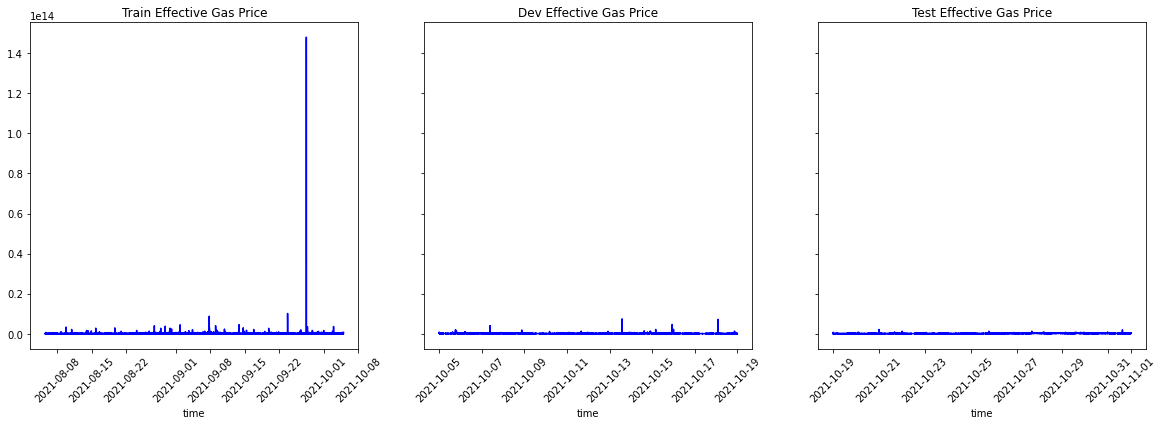

In [25]:
fig, ax1 = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

ax1[0].plot(X_train['datetime'], Y_train, color='blue')
ax1[0].set_xlabel('time')
ax1[0].tick_params(axis='x', labelrotation=45)
ax1[0].set_title('Train Effective Gas Price')
#plt.show()

ax1[1].plot(X_dev['datetime'], Y_dev, color='blue')
ax1[1].set_xlabel('time')
ax1[1].tick_params(axis='x', labelrotation=45)
ax1[1].set_title('Dev Effective Gas Price')
#plt.show()

ax1[2].plot(X_test['datetime'], Y_test, color='blue')
ax1[2].set_xlabel('time')
ax1[2].tick_params(axis='x', labelrotation=45)
ax1[2].set_title('Test Effective Gas Price')
plt.show()

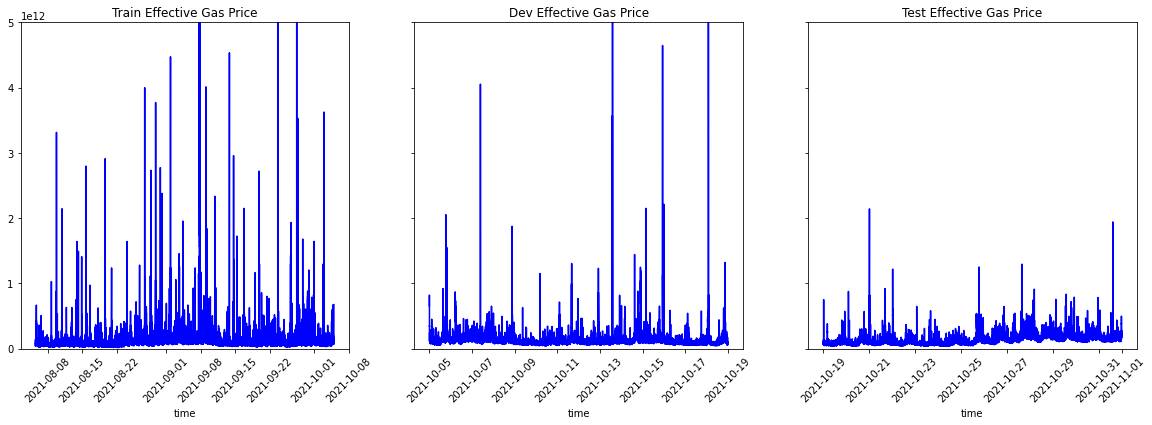

In [26]:
fig, ax1 = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

ax1[0].plot(X_train['datetime'], Y_train, color='blue')
ax1[0].set_xlabel('time')
ax1[0].tick_params(axis='x', labelrotation=45)
ax1[0].set_title('Train Effective Gas Price')
ax1[0].set_ylim(0, 5000000000000)
#plt.show()

ax1[1].plot(X_dev['datetime'], Y_dev, color='blue')
ax1[1].set_xlabel('time')
ax1[1].tick_params(axis='x', labelrotation=45)
ax1[1].set_title('Dev Effective Gas Price')
ax1[1].set_ylim(0, 5000000000000)
#plt.show()

ax1[2].plot(X_test['datetime'], Y_test, color='blue')
ax1[2].set_xlabel('time')
ax1[2].tick_params(axis='x', labelrotation=45)
ax1[2].set_title('Test Effective Gas Price')
ax1[2].set_ylim(0, 5000000000000)
plt.show()

In [27]:
Y_train.describe(percentiles=[.01, .05, .10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,effective_gas_price_mean
count,3.842080e+05
mean,9.286160e+10
std,2.699985e+11
min,1.596813e+10
1%,2.840455e+10
5%,3.649671e+10
10%,4.178856e+10
25%,5.292405e+10
50%,7.258091e+10
75%,1.014388e+11


## Linear Regression

#### Create a heatmap to limit multicollinearity when testing regressions

In [ ]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap of Features', fontdict={'fontsize':12}, pad=12);

#### Manually create feature list

In [28]:
lin_reg_features_list = [
    ['base_fee_per_gas_pct_chg_last_25_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_25_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_25_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_25_to_5', 'effective_gas_price_mean_pct_chg_last_5'],
    ['base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5'],
    ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_100_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5']
 ]

#### Run Regressions

In [29]:
# Prep the results dataframe

# Collapse the list of features into one field
temp_list = []
for i in range(len(lin_reg_features_list)):
    temp_list.append(','.join(lin_reg_features_list[i]))
linear_regression_results_df = pd.DataFrame(temp_list,
                                            columns=['Features'])

# Create empty columns for the results
linear_regression_results_df['Coefficients'] = ''
linear_regression_results_df['Rsq_Train'] = ''
linear_regression_results_df['Rsq_Dev'] = ''
linear_regression_results_df['RMSE_Train'] = ''
linear_regression_results_df['RMSE_Dev'] = ''
linear_regression_results_df.head()

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...",,,,,
1,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...",,,,,
2,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...",,,,,


In [30]:
lr_coeff_list = []
lr_rmse_train_list = []
lr_rmse_dev_list = []
lr_rsq_train_list = []
lr_rsq_dev_list = []

for l in lin_reg_features_list:
    lin_reg = LinearRegression(normalize=True, n_jobs=-1)

    lin_reg_features = l

    # fit train and test data. 
    lin_reg.fit(X_train[l], Y_train)

    # Predict train data. 
    y_train_pred = lin_reg.predict(X_train[l])

    # Get training metrics
    lr_mse_train = mean_squared_error(Y_train, y_train_pred)
    lr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    lr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

    # Predict dev data. 
    y_dev_pred_lr = lin_reg.predict(X_dev[l])

    lr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_lr)
    lr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_lr))
    lr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_lr)
    
    # Store all of the results in lists
    lr_coeff_list.append(lin_reg.coef_)
    lr_rmse_train_list.append(lr_rmse_train)
    lr_rmse_dev_list.append(lr_rmse_dev)
    lr_rsq_train_list.append(lr_r2score_train)
    lr_rsq_dev_list.append(lr_r2score_dev)

# Store the lists of results into the results dataframe
linear_regression_results_df['Coefficients'] = lr_coeff_list
linear_regression_results_df['RMSE_Train'] = lr_rmse_train_list
linear_regression_results_df['RMSE_Dev'] = lr_rmse_dev_list
linear_regression_results_df['Rsq_Train'] = lr_rsq_train_list
linear_regression_results_df['Rsq_Dev'] = lr_rsq_dev_list

linear_regression_results_df.head()

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...","[[145762968837.11026, 82383010999.61008, 4.396...",0.838347,0.230237,1.085558e+11,1.217302e+11
1,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...","[[71518161793.01581, 77683037705.2249, 1249091...",0.858095,0.261750,1.017091e+11,1.192124e+11
2,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...","[[62512635056.39146, 81637436872.56473, 1.0466...",0.865064,0.291929,9.918001e+10,1.167503e+11


#### Run Final Linear Regression Model

In [31]:
# Call in the LinearRegression object
lin_reg = LinearRegression(normalize=True, n_jobs=-1)

lin_reg_features = ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_100_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5']


# fit train and test data. 
lin_reg.fit(X_train[lin_reg_features], Y_train)

# Predict train data. 
y_train_pred = lin_reg.predict(X_train[lin_reg_features])

# Get training metrics
lr_mse_train = mean_squared_error(Y_train, y_train_pred)
lr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
lr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

print ('The MSE of the Linear Regression model on train data is: %.4f'%lr_mse_train)
print ('The RMSE of the Linear Regression model on train data is: %.4f'%lr_rmse_train)
print ('The R^2 of the Linear Regression model on train data is: %.4f'%lr_r2score_train)

# Predict dev data. 
y_dev_pred_lr = lin_reg.predict(X_dev[lin_reg_features])

lr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_lr)
lr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_lr))
lr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_lr)

print ('The MSE of the Linear Regression model on dev data is: %.4f'%lr_mse_dev)
print ('The RMSE of the Linear Regression model on dev data is: %.4f'%lr_rmse_dev)
print ('The R^2 of the Linear Regression model on dev data is: %.4f'%lr_r2score_dev)

lin_reg.coef_

The MSE of the Linear Regression model on train data is: 9836673722503143620608.0000
The RMSE of the Linear Regression model on train data is: 99180006667.1864
The R^2 of the Linear Regression model on train data is: 0.8651
The MSE of the Linear Regression model on dev data is: 13630640423540707295232.0000
The RMSE of the Linear Regression model on dev data is: 116750333719.1835
The R^2 of the Linear Regression model on dev data is: 0.2919


array([[ 6.25126351e+10,  8.16374369e+10,  1.04662562e+24,
        -5.05315923e+21, -9.93715012e+05,  9.40460912e+07,
        -1.04662562e+24,  5.05315923e+21]])

In [32]:
import statsmodels.api as sm
mod = sm.OLS(Y_train,X_train[lin_reg_features])
mod2 = mod.fit()
print(mod2.summary())

                                    OLS Regression Results                                   
Dep. Variable:     effective_gas_price_mean   R-squared (uncentered):                   0.802
Model:                                  OLS   Adj. R-squared (uncentered):              0.802
Method:                       Least Squares   F-statistic:                          2.600e+05
Date:                      Tue, 16 Nov 2021   Prob (F-statistic):                        0.00
Time:                              17:30:36   Log-Likelihood:                     -1.0368e+07
No. Observations:                    384208   AIC:                                  2.074e+07
Df Residuals:                        384202   BIC:                                  2.074e+07
Df Model:                                 6                                                  
Covariance Type:                  nonrobust                                                  
                                                         coe

In [33]:
linear_regression_results_df.to_csv(r'data/linear_regression_results_20211116_NoSize.csv')

In [34]:
#len(y_dev_pred_lr)
#X_train
Y_dev['effective_gas_price_mean']

384308    6.559103e+11
384309    7.362075e+11
384310    7.663225e+11
384311    7.900478e+11
384312    7.714207e+11
              ...     
471935    9.101150e+10
471936    8.784644e+10
471937    9.296818e+10
471938    8.356565e+10
471939    8.613604e+10
Name: effective_gas_price_mean, Length: 87632, dtype: float64

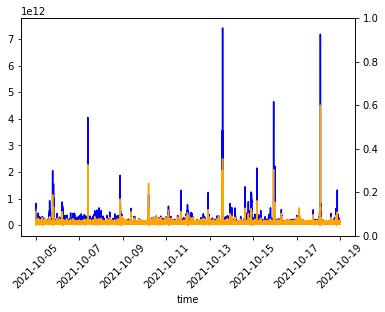

In [35]:
x = X_dev['datetime']
y1 = Y_dev
y2 = y_dev_pred_lr
y3 = Y_dev - y_dev_pred_lr

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, color='blue')
ax1.plot(x, y2, color='orange')
#ax2.plot(x, y3, color='red')

ax1.set_xlabel('time')
#ax1.set_ylabel('base_fee_per_gas')
#ax2.set_ylabel('gas_limit')
ax1.tick_params(axis='x', labelrotation=45)
plt.show()

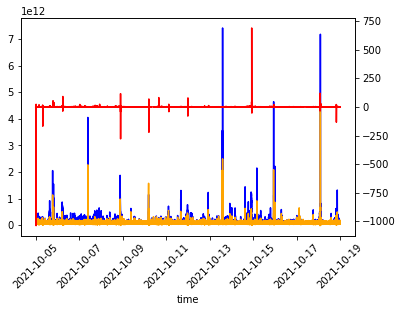

In [36]:
x = X_dev['datetime']
y1 = Y_dev
y2 = y_dev_pred_lr
y3 = (Y_dev - y_dev_pred_lr) / y_dev_pred_lr

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, color='blue')
#ax2.plot(x, y2, color='orange')
ax1.plot(x, y2, color='orange')
ax2.plot(x, y3, color='red')

ax1.set_xlabel('time')
#ax1.set_ylabel('base_fee_per_gas')
#ax2.set_ylabel('gas_limit')
ax1.tick_params(axis='x', labelrotation=45)
plt.show()

In [37]:
y3.sort_values(by='effective_gas_price_mean')

,effective_gas_price_mean
384417,-1037.988223
408851,-279.399720
417020,-221.662161
386354,-168.651071
470879,-133.794706
...,...
408836,115.837423
466189,119.701500
446530,181.810018
446532,283.701826


In [38]:
print(X_dev['datetime'].shape)
print(X_dev.index.shape)
print(np.array(Y_dev).flatten().shape)
print(y_dev_pred_lr.flatten())

(87632,)
(87632,)
(87632,)
[5.01064342e+11 4.87105698e+11 4.46303509e+11 ... 1.11941982e+11
 8.15332784e+10 8.40282494e+10]


In [39]:
lr_check_df = pd.DataFrame({'dt': X_dev['datetime'], 
                            'block_number': X_dev.index, 
                            'y': np.array(Y_dev).flatten(), 
                            'y_pred': y_dev_pred_lr.flatten()},
                          columns = ['dt', 'block_number', 'y', 'y_pred'])
lr_check_df

,dt,block_number,y,y_pred
384308,2021-10-05 00:00:19,384308,6.559103e+11,5.010643e+11
384309,2021-10-05 00:00:34,384309,7.362075e+11,4.871057e+11
384310,2021-10-05 00:00:58,384310,7.663225e+11,4.463035e+11
384311,2021-10-05 00:01:05,384311,7.900478e+11,4.344923e+11
384312,2021-10-05 00:01:13,384312,7.714207e+11,4.581147e+11
...,...,...,...,...
471935,2021-10-18 23:58:48,471935,9.101150e+10,8.012399e+10
471936,2021-10-18 23:58:55,471936,8.784644e+10,9.529060e+10
471937,2021-10-18 23:59:43,471937,9.296818e+10,1.119420e+11
471938,2021-10-18 23:59:50,471938,8.356565e+10,8.153328e+10


In [40]:
lr_check_df['diff'] = lr_check_df.y_pred - lr_check_df.y
lr_check_df['pct_diff'] = (lr_check_df.y_pred - lr_check_df.y)/lr_check_df.y
lr_check_df['abs_pct_diff'] = abs(lr_check_df['pct_diff'])
lr_check_df.sort_values(by='abs_pct_diff', ascending=False)

,dt,block_number,y,y_pred,diff,pct_diff,abs_pct_diff
468133,2021-10-18 09:17:49,468133,6.841539e+10,1.485079e+11,8.009254e+10,1.170680e+00,1.170680e+00
466184,2021-10-18 01:45:51,466184,1.652706e+11,-2.043864e+10,-1.857092e+11,-1.123668e+00,1.123668e+00
468542,2021-10-18 10:50:32,468542,5.217520e+10,1.100378e+11,5.786257e+10,1.109005e+00,1.109005e+00
418422,2021-10-10 10:17:54,418422,6.691102e+10,1.401529e+11,7.324185e+10,1.094616e+00,1.094616e+00
468557,2021-10-18 10:54:15,468557,6.632891e+10,1.388610e+11,7.253211e+10,1.093522e+00,1.093522e+00
...,...,...,...,...,...,...,...
461306,2021-10-17 07:10:15,461306,1.042461e+11,1.042496e+11,3.495797e+06,3.353407e-05,3.353407e-05
432789,2021-10-12 17:16:20,432789,9.680338e+10,9.680054e+10,-2.831831e+06,-2.925343e-05,2.925343e-05
386971,2021-10-05 09:56:51,386971,7.978935e+10,7.978845e+10,-8.973929e+05,-1.124703e-05,1.124703e-05
469498,2021-10-18 14:29:44,469498,8.072778e+10,8.072797e+10,1.931278e+05,2.392333e-06,2.392333e-06


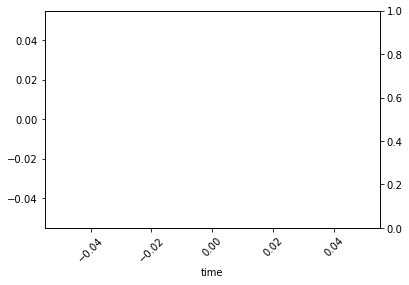

In [41]:
x = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['block_number']
y1 = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['y']
y2 = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['y_pred']
y3 = lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]['pct_diff']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, color='blue')
ax1.plot(x, y2, color='orange')
#ax2.plot(x, y3, color='red')

ax1.set_xlabel('time')
#ax1.set_ylabel('base_fee_per_gas')
#ax2.set_ylabel('gas_limit')
ax1.tick_params(axis='x', labelrotation=45)
plt.show()

In [42]:
lr_check_df[(lr_check_df.block_number>477360)&(lr_check_df.block_number<477400)]

,dt,block_number,y,y_pred,diff,pct_diff,abs_pct_diff


In [43]:
X_dev.loc[477360:477400][lin_reg_features]

,base_fee_per_gas_pct_chg_last_100_to_5,base_fee_per_gas_pct_chg_last_5,gas_price_mean_pct_chg_last_100_to_5,gas_price_mean_pct_chg_last_5,number_transactions_in_block_pct_chg_last_100_to_5,number_transactions_in_block_pct_chg_last_5,effective_gas_price_mean_pct_chg_last_100_to_5,effective_gas_price_mean_pct_chg_last_5


In [44]:
data.loc[477393]['size']

44625

In [45]:
data.loc[477292]['size']

121063

In [46]:
X_dev.columns

Index(['lag_cutoff_60', 'latest_avail_60', 'datetime', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used', 'timestamp',
       'transaction_count', 'base_fee_per_gas', 'timestamp_2',
       'difficulty_pct_chg_last_5', 'difficulty_pct_chg_last_25_to_5',
       'difficulty_pct_chg_last_50_to_5', 'difficulty_pct_chg_last_100_to_5',
       'total_difficulty_pct_chg_last_5',
       'total_difficulty_pct_chg_last_25_to_5',
       'total_difficulty_pct_chg_last_50_to_5',
       'total_difficulty_pct_chg_last_100_to_5', 'gas_limit_pct_chg_last_5',
       'gas_limit_pct_chg_last_25_to_5', 'gas_limit_pct_chg_last_50_to_5',
       'gas_limit_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
       'base_fee_per_gas_pct_chg_last_25_to_5',
       'base_fee_per_gas_pct_chg_last_50_to_5',
       'base_fee_per_gas_pct_chg_last_100_to_5', 'gas_min', 'gas_mean',
       'gas_price_min', 'gas_price_mean', 'gas_used_min', 'gas_used_mean',
       'number_transactions_in_block

## Ridge Regression

In [47]:
# Prep the results dataframe

# Collapse the list of features into one field
temp_list = []
for i in range(len(lin_reg_features_list)):
    temp_list.append(','.join(lin_reg_features_list[i]))
ridge_regression_results_df = pd.DataFrame(temp_list,
                                            columns=['Features'])

# Create empty columns for the results
ridge_regression_results_df['Coefficients'] = ''
ridge_regression_results_df['Rsq_Train'] = ''
ridge_regression_results_df['Rsq_Dev'] = ''
ridge_regression_results_df['RMSE_Train'] = ''
ridge_regression_results_df['RMSE_Dev'] = ''
ridge_regression_results_df.head()

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...",,,,,
1,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...",,,,,
2,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...",,,,,


In [48]:
rr_coeff_list = []
rr_rmse_train_list = []
rr_rmse_dev_list = []
rr_rsq_train_list = []
rr_rsq_dev_list = []

for l in lin_reg_features_list:
    ridge_reg = Ridge(alpha=0.75, random_state=42)

    lin_reg_features = l

    # fit train and test data. 
    ridge_reg.fit(X_train[lin_reg_features], Y_train)

    # Predict train data. 
    y_train_pred_rr = ridge_reg.predict(X_train[lin_reg_features])

    # Get training metrics
    rr_mse_train = mean_squared_error(Y_train, y_train_pred)
    rr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
    rr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

    # Predict dev data. 
    y_dev_pred_rr = ridge_reg.predict(X_dev[lin_reg_features])

    rr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_rr)
    rr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_rr))
    rr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_rr)
    
    # Store all of the results in lists
    rr_coeff_list.append(ridge_reg.coef_)
    rr_rmse_train_list.append(rr_rmse_train)
    rr_rmse_dev_list.append(rr_rmse_dev)
    rr_rsq_train_list.append(rr_r2score_train)
    rr_rsq_dev_list.append(rr_r2score_dev)

# Store the lists of results into the results dataframe
ridge_regression_results_df['Coefficients'] = rr_coeff_list
ridge_regression_results_df['RMSE_Train'] = rr_rmse_train_list
ridge_regression_results_df['RMSE_Dev'] = rr_rmse_dev_list
ridge_regression_results_df['Rsq_Train'] = rr_rsq_train_list
ridge_regression_results_df['Rsq_Dev'] = rr_rsq_dev_list

ridge_regression_results_df.head()

,Features,Coefficients,Rsq_Train,Rsq_Dev,RMSE_Train,RMSE_Dev
0,"base_fee_per_gas_pct_chg_last_25_to_5,base_fee...","[[145742140157.05725, 82398020007.69203, 63925...",0.865064,0.230541,9.918001e+10,1.217061e+11
1,"base_fee_per_gas_pct_chg_last_50_to_5,base_fee...","[[71517902440.53299, 77676796803.4806, 1249099...",0.865064,0.261750,9.918001e+10,1.192125e+11
2,"base_fee_per_gas_pct_chg_last_100_to_5,base_fe...","[[62193921004.36354, 85854922254.81929, 133523...",0.865064,0.296526,9.918001e+10,1.163707e+11


In [49]:

lin_reg_features = ['base_fee_per_gas_pct_chg_last_100_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_100_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_100_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_100_to_5', 'effective_gas_price_mean_pct_chg_last_5']

#Instantiate regression
ridge_reg = Ridge(alpha=0.75, random_state=42)

# fit train and test data. 
ridge_reg.fit(X_train[lin_reg_features], Y_train)

# Predict train data. 
y_train_pred_rr = ridge_reg.predict(X_train[lin_reg_features])

# Get training metrics
rr_mse_train = mean_squared_error(Y_train, y_train_pred)
rr_rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))
rr_r2score_train = metrics.r2_score(Y_train, y_train_pred)

print ('The MSE of the Ridge Regression model on train data is: %.4f'%rr_mse_train)
print ('The RMSE of the Ridge Regression model on train data is: %.4f'%rr_rmse_train)
print ('The R^2 of the Ridge Regression model on train data is: %.4f'%rr_r2score_train)

# Predict dev data. 
y_dev_pred_rr = ridge_reg.predict(X_dev[lin_reg_features])

rr_mse_dev = mean_squared_error(Y_dev, y_dev_pred_rr)
rr_rmse_dev = np.sqrt(mean_squared_error(Y_dev, y_dev_pred_rr))
rr_r2score_dev = metrics.r2_score(Y_dev, y_dev_pred_rr)

print ('The MSE of the Ridge Regression model on dev data is: %.4f'%rr_mse_dev)
print ('The RMSE of the Ridge Regression model on dev data is: %.4f'%rr_rmse_dev)
print ('The R^2 of the Ridge Regression model on dev data is: %.4f'%rr_r2score_dev)

print("coefficients:", ridge_reg.coef_)

The MSE of the Ridge Regression model on train data is: 9836673722503143620608.0000
The RMSE of the Ridge Regression model on train data is: 99180006667.1864
The R^2 of the Ridge Regression model on train data is: 0.8651
The MSE of the Ridge Regression model on dev data is: 13542148753331238993920.0000
The RMSE of the Ridge Regression model on dev data is: 116370738389.5592
The R^2 of the Ridge Regression model on dev data is: 0.2965
coefficients: [[6.21939210e+10 8.58549223e+10 1.33523225e+09 2.90552667e+10
  3.05153081e+06 8.90666694e+07 1.33523224e+09 2.90552667e+10]]


In [50]:
ridge_regression_results_df.to_csv(r'data/ridge_regression_results_20211116_NoSize.csv')

## Random Forest

#### Hyperparameter Tuning Random Search

In [55]:
n_estimators = [100, 200, 500, 1000]
max_depth = [2, 3, 5, 7, 10]
max_features = [3, 4, 5, 7, 8]
min_samples_leaf = [5, 10, 25, 50, 100, 200, 500]

rf_hyperparameters = []
for i in range(10):
    ne = random.randint(0, len(n_estimators)-1)
    md = random.randint(0, len(max_depth)-1)
    mf = random.randint(0, len(max_features)-1)
    msl = random.randint(0, len(min_samples_leaf)-1)
    rf_hyperparameters.append([n_estimators[ne],
                               max_depth[md],
                               max_features[mf],
                               min_samples_leaf[msl]])
rf_hyperparameters_df = pd.DataFrame(rf_hyperparameters,
                                  columns=['n_estimators',
                                           'max_depth',
                                           'max_features',
                                           'min_samples_leaf'])
print(rf_hyperparameters_df)


   n_estimators  max_depth  max_features  min_samples_leaf
0           100          7             4                10
1          1000          3             5                 5
2           200          3             5               500
3           100         10             8                 5
4           500         10             3                25
5           200          5             7                50
6          1000          3             4                25
7           100          5             5                25
8           500         10             4               200
9           500          5             4                50


#### Run the random forest models

In [56]:
print(datetime.datetime.now())

2021-11-16 20:09:29.234351


In [ ]:
# Set the random forest features
rf_features = ['base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']


# Set the index of the list of hyperparameters
ne_idx = 0
md_idx = 1
mf_idx = 2
msl_idx = 3

# Initialize rmse lists of models
rf_RMSE_train_list = []
rf_RMSE_dev_list = []

counter = 1

# Loop through hyperparameters and run random forest models
for h in range(len(rf_hyperparameters)):
    
    # Instantiate the random forest
    rf = RandomForestRegressor(n_estimators = rf_hyperparameters[h][ne_idx], 
                               max_depth = rf_hyperparameters[h][ne_idx],
                               bootstrap = True,
                               max_features = rf_hyperparameters[h][mf_idx],
                               min_samples_leaf = rf_hyperparameters[h][msl_idx],
                               random_state = 42)

    # Train the model on the training data
    rf.fit(X_train[rf_features], Y_train)

    # Get the predictions on the training data set
    rf_train_predictions = rf.predict(X_train[rf_features])

    # Get the predictions on the dev data set
    rf_dev_predictions = rf.predict(X_dev[rf_features])


    rf_MSE_train = mean_squared_error(Y_train, rf_train_predictions)
    rf_RMSE_train = np.sqrt(rf_MSE_train)
    rf_MSE_dev = mean_squared_error(Y_dev, rf_dev_predictions)
    rf_RMSE_dev = np.sqrt(rf_MSE_dev)
    rf_RMSE_train_list.append(rf_RMSE_train)
    rf_RMSE_dev_list.append(rf_RMSE_dev)
    
    # Purely to show progress
    print("Model #", counter)
    counter += 1

# Append the RMSE's to the dataframe
rf_hyperparameters_df['RMSE_Train'] = rf_RMSE_train_list
rf_hyperparameters_df['RMSE_Dev'] = rf_RMSE_dev_list

Model # 1
Model # 2
Model # 3
Model # 4
Model # 5
Model # 6


In [ ]:
print(datetime.datetime.now())

In [ ]:
rf_hyperparameters_df.sort_values(by='RMSE_Dev')

In [ ]:
rf_hyperparameters_df.to_csv(r'data/rf_hyperparameters_20211116_NoSize.csv')

#### Run the Final Random Forest Model After Picking Hyperparameters

In [ ]:
rf_features = ['base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']


In [ ]:
# Instantiate the random forest
rf = RandomForestRegressor(n_estimators = 1000, 
                           max_depth = 10,
                           bootstrap = True,
                           max_features = 7,
                           min_samples_leaf = 25,
                           random_state = 42)

# Train the model on the training data
rf.fit(X_train[rf_features], Y_train)

# Get the predictions on the training data set
rf_train_predictions = rf.predict(X_train[rf_features])

# Get the predictions on the dev data set
rf_dev_predictions = rf.predict(X_dev[rf_features])


rf_MSE_train = mean_squared_error(Y_train, rf_train_predictions)
rf_RMSE_train = np.sqrt(rf_MSE_train)
rf_MSE_dev = mean_squared_error(Y_dev, rf_dev_predictions)
rf_RMSE_dev = np.sqrt(rf_MSE_dev)
print("rf_RMSE_train:", rf_RMSE_train)
print("rf_RMSE_dev:", rf_RMSE_dev)

#### Feature Importance

In [ ]:
rf_feature_importances = rf.feature_importances_
rf_feature_importances_dict = {'Features': rf_features,
                               'Feature_Importance': rf_feature_importances}
rf_feature_importances_df = pd.DataFrame(rf_feature_importances_dict)
rf_feature_importances_df.sort_values(by=['Feature_Importance'], 
                                      ascending=False,
                                      inplace=True)
print(rf_feature_importances_df.head(30))

rf_feature_importances_df = rf_feature_importances_df.set_index('Features')
rf_feature_importances_df['Feature_Importance'].nlargest(15).plot(kind='barh',
                                                                  title='Random Forest Feature Importance')

In [ ]:
data.columns

## Gradient Boosting

#### Hyperparameter Tuning Random Search

In [ ]:
# Gradient boosing hyperparameter random search
booster = ['dart', 'gbtree', 'gblinear']
max_depth = [2, 3, 5, 6, 7, 10]
learning_rate = [.001, .005, .01, .05]
subsample = [0.5, 0.6, 0.7]
rate_drop = [0.00, 0.10, 0.20, 0.40]
min_child_weight = [1, 5, 10, 25, 50, 100, 200, 500]
training_rounds = [200, 500, 1000]

xgb_hyperparameters = []
for i in range(10):
    
    # Randomly pick from specific hyperparameter lists
    b = random.randint(0, len(booster)-1)
    md = random.randint(0, len(max_depth)-1)
    l = random.randint(0, len(learning_rate)-1)
    s = random.randint(0, len(subsample)-1)
    r = random.randint(0, len(rate_drop)-1)
    mcw = random.randint(0, len(min_child_weight)-1)
    t = random.randint(0, len(training_rounds)-1)
    
    xgb_hyperparameters.append([booster[b],
                                max_depth[md],
                                learning_rate[l],
                                subsample[s],
                                rate_drop[r],
                                min_child_weight[mcw],
                                training_rounds[t]])

# Store randomly chosen hyperparameters into dataframe
xgb_hyperparameters_df = pd.DataFrame(xgb_hyperparameters,
                                      columns=['booster',
                                               'max_depth',
                                               'learning_rate',
                                               'subsample',
                                               'rate_drop',
                                               'min_child_weight',
                                               'training_rounds'])

In [ ]:
xgb_hyperparameters_df

#### Run the gradient boosting models

In [ ]:
# Set the gradient boosting features
xgb_features = ['base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']

# Set the index of the list of hyperparameters
b_idx = 0
md_idx = 1
l_idx = 2
s_idx = 3
r_idx = 4
mcw_idx = 5
t_idx = 6

# Initialize rmse lists of models
xgb_RMSE_train_list = []
xgb_RMSE_dev_list = []

# Loop through hyperparameters and run random forest models
for h in range(len(xgb_hyperparameters)):
    
    #set up the training matrix
    dtrain = xgb.DMatrix(X_train[xgb_features], label=Y_train)
    xgb_dict = {
            'booster': xgb_hyperparameters[h][b_idx],
            'max_depth': xgb_hyperparameters[h][md_idx],
            'random_state': 42,
            'learning_rate': xgb_hyperparameters[h][l_idx],
            'objective': 'reg:squarederror',
            'verbosity': 0,
            'sample_type': 'uniform',
            'subsample': xgb_hyperparameters[h][s_idx],
            'normalize_type': 'tree',
            'rate_drop': xgb_hyperparameters[h][r_idx],
            'min_child_weight': xgb_hyperparameters[h][mcw_idx]
        }
    #starting hyperparameter of training rounds
    training_rounds = xgb_hyperparameters[h][t_idx]

    #train the model
    bst = xgb.train(
        xgb_dict,
        dtrain,
        training_rounds,
        evals=[(xgb.DMatrix(X_dev[xgb_features], label=Y_dev), 'RMSE')],
        early_stopping_rounds=10) 


    training_rounds = bst.best_ntree_limit

    #get training predictions and MSE
    xgb_train_pred = bst.predict(xgb.DMatrix(X_train[xgb_features]), ntree_limit=training_rounds)
    xgb_train_mse = mean_squared_error(xgb_train_pred, Y_train)
    xgb_train_rmse = np.sqrt(xgb_train_mse)

    #get dev predictions and MSE
    xgb_dev_pred = bst.predict(xgb.DMatrix(X_dev[xgb_features]), ntree_limit=training_rounds)
    xgb_dev_mse = mean_squared_error(xgb_dev_pred, Y_dev)
    xgb_dev_rmse = np.sqrt(xgb_dev_mse)

    xgb_RMSE_train_list.append(xgb_train_rmse)
    xgb_RMSE_dev_list.append(xgb_dev_rmse)


# Append the RMSE's to the dataframe
xgb_hyperparameters_df['RMSE_Train'] = xgb_RMSE_train_list
xgb_hyperparameters_df['RMSE_Dev'] = xgb_RMSE_dev_list

In [ ]:
xgb_hyperparameters_df.sort_values(by='RMSE_Dev')

In [ ]:
xgb_hyperparameters_df.to_csv(r'data/xgb_hyperparameters_20211115_NoSize.csv')

#### Run the Final Gradient Boosting Model After Picking Hyperparameters

In [ ]:
xgb_features = ['base_fee_per_gas_pct_chg_last_50_to_5', 'base_fee_per_gas_pct_chg_last_5',
             'gas_price_mean_pct_chg_last_50_to_5', 'gas_price_mean_pct_chg_last_5',
             'number_transactions_in_block_pct_chg_last_50_to_5', 'number_transactions_in_block_pct_chg_last_5',
             'effective_gas_price_mean_pct_chg_last_50_to_5', 'effective_gas_price_mean_pct_chg_last_5']

In [ ]:
#set up the training matrix
dtrain = xgb.DMatrix(X_train[xgb_features], label=Y_train)
xgb_dict = {
        'booster': 'gbtree',
        'max_depth': 7,
        'random_state': 42,
        'learning_rate': .01,
        'objective': 'reg:squarederror',
        'verbosity': 0,
        'sample_type': 'uniform',
        'subsample': 0.7,
        'normalize_type': 'tree',
        'rate_drop': 0.4,
        'min_child_weight': 1
    }
#starting hyperparameter of training rounds
training_rounds = 200

#train the model
bst = xgb.train(
    xgb_dict,
    dtrain,
    training_rounds,
    evals=[(xgb.DMatrix(X_dev[xgb_features], label=Y_dev), 'RMSE')],
    early_stopping_rounds=10) 


training_rounds = bst.best_ntree_limit

#get training predictions and MSE
xgb_train_pred = bst.predict(xgb.DMatrix(X_train[xgb_features]), ntree_limit=training_rounds)
xgb_train_mse = mean_squared_error(xgb_train_pred, Y_train)
xgb_train_rmse = np.sqrt(xgb_train_mse)

#print("XGB train mean squared error:", xgb_train_mse)
print("XGB train root mean squared error:", xgb_train_rmse)

#get dev predictions and MSE
xgb_dev_pred = bst.predict(xgb.DMatrix(X_dev[xgb_features]), ntree_limit=training_rounds)
xgb_dev_mse = mean_squared_error(xgb_dev_pred, Y_dev)
xgb_dev_rmse = np.sqrt(xgb_dev_mse)

#print("XGB dev mean squared error:", xgb_dev_mse)
print("XGB dev root mean squared error:", xgb_dev_rmse)

In [ ]:
#feature importance
xgb_importance_weight = bst.get_score(importance_type='weight')
xgb_importance_gain = bst.get_score(importance_type='gain')
xgb_importance_weight_df = pd.DataFrame.from_dict(xgb_importance_weight,
                                                  orient='index',
                                                  columns=['weight'])
xgb_importance_gain_df = pd.DataFrame.from_dict(xgb_importance_gain,
                                                  orient='index',
                                                  columns=['gain'])
xgb_feature_importance_df = xgb_importance_weight_df.join(xgb_importance_gain_df)
xgb_feature_importance_df.sort_values(by=['weight'], ascending=False, inplace=True)                 
print(xgb_feature_importance_df.head(30))


In [ ]:
plot_importance(bst, max_num_features=30)

## Loading From File

In [44]:
lr_results_from_file = pd.read_csv(r'data/linear_regression_results.csv')
lr_results_from_file['Model'] = 'Linear Regression'
lr_results_from_file = lr_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in lr_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]

rr_results_from_file = pd.read_csv(r'data/ridge_regression_results.csv')
rr_results_from_file['Model'] = 'Ridge Regression'
rr_results_from_file = rr_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in rr_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]

rf_results_from_file = pd.read_csv(r'data/rf_hyperparameters.csv')
rf_results_from_file['Model'] = 'Random Forest'
rf_results_from_file = rf_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in rf_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]

xgb_results_from_file = pd.read_csv(r'data/xgb_hyperparameters.csv')
xgb_results_from_file['Model'] = 'Gradient Boosting'
xgb_results_from_file = xgb_results_from_file[['Model', 'RMSE_Dev', 'RMSE_Train'] + [c for c in xgb_results_from_file.columns if c not in ['Model', 'RMSE_Dev', 'RMSE_Train']]]


In [45]:
results_all_df = lr_results_from_file.append(rr_results_from_file).append(rf_results_from_file).append(xgb_results_from_file)

In [47]:
results_all_df = results_all_df.sort_values(by=['RMSE_Dev', 'RMSE_Train'])
results_all_df

,Model,RMSE_Dev,RMSE_Train,Unnamed: 0,Features,Coefficients,Rsq_Train,Rsq_Dev,n_estimators,max_depth,max_features,min_samples_leaf,booster,learning_rate,subsample,rate_drop,min_child_weight,training_rounds
2,Random Forest,8.201272e+10,2.423501e+11,2,NaN,NaN,NaN,NaN,1000.0,10.0,7.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
5,Random Forest,8.251172e+10,2.423941e+11,5,NaN,NaN,NaN,NaN,500.0,2.0,5.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
6,Random Forest,8.606034e+10,2.462958e+11,6,NaN,NaN,NaN,NaN,100.0,10.0,10.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
9,Random Forest,8.705298e+10,2.462476e+11,9,NaN,NaN,NaN,NaN,1000.0,10.0,5.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Random Forest,8.706493e+10,2.462468e+11,4,NaN,NaN,NaN,NaN,200.0,7.0,5.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Random Forest,8.902324e+10,2.464465e+11,3,NaN,NaN,NaN,NaN,500.0,5.0,3.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
0,Random Forest,9.560334e+10,2.493508e+11,0,NaN,NaN,NaN,NaN,1000.0,2.0,4.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
6,Gradient Boosting,9.563024e+10,1.315841e+11,6,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,gbtree,0.010,0.7,0.4,1.0,200.0
1,Random Forest,1.026660e+11,2.522471e+11,1,NaN,NaN,NaN,NaN,1000.0,3.0,10.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Gradient Boosting,1.030321e+11,2.515721e+11,8,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,dart,0.050,0.5,0.0,200.0,200.0


## Ensemble

In [57]:
ensemble_train_preds = (y_train_pred.ravel() + y_train_pred_rr.ravel() + rf_train_predictions + xgb_train_pred) / 4
print("train_rmse =", np.sqrt(mean_squared_error(ensemble_train_preds, Y_train)))


train_rmse = 116178775490.90768


In [59]:
ensemble_dev_preds = (y_dev_pred_lr.ravel() + y_dev_pred_rr.ravel() + rf_dev_predictions + xgb_dev_pred) / 4
print("dev_rmse =", np.sqrt(mean_squared_error(ensemble_dev_preds, Y_dev)))

dev_rmse = 97696145767.18451
